<a href="https://colab.research.google.com/github/pakdaniel/MECS-4995-AML-Group-24/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


pth = "met_gas_site_cleaned.snappy.parquet"
def generate_datasets(pth):

  df = pd.read_parquet(pth)
  df["year"] = df["DATE_TIME"].dt.year
  df["month"] = df["DATE_TIME"].dt.month
  df["LATITUDE"] = df["LATITUDE"].astype("float")
  df["LONGITUDE"] = df["LONGITUDE"].astype("float")

  categorical_columns = ['LAND_USE', 'TERRAIN']
  for feature in categorical_columns:
      encoder = OneHotEncoder()
      encoded_data = encoder.fit_transform(df[[feature]])
      df[encoder.categories_[0]] = encoded_data.toarray()


  drop_columns = ['OZONE', "year", "DATE_TIME", "SITE_ID", "QA_CODE", "WINDSPEED", "SIGMA_THETA"] + categorical_columns
  df_train = df[df['year'].isin([2013, 2014, 2015, 2016, 2017, 2018])]
  X_train, y_train = df_train.drop(columns=drop_columns, axis=1), df_train['OZONE']

  columns = X_train.columns

  numerical_features = ['TEMPERATURE',
                        'RELATIVE_HUMIDITY',
                        'SOLAR_RADIATION',
                        'PRECIPITATION',
                        'WIND_DIRECTION',
                        'FLOW_RATE',
                        'WINDSPEED_SCALAR',
                        'SHELTER_TEMPERATURE',
                        'NO',
                        'NOY',
                        'NOYDIF',
                        'SO2_GA',
                        'LATITUDE',
                        'LONGITUDE',
                        'ELEVATION']

  ct = ColumnTransformer([
          ('Standardize Numerical Features', StandardScaler(), numerical_features)
      ], remainder='passthrough')
  X_train = ct.fit_transform(X_train)

  df_val = df[df['year'].isin([2019, 2020])]
  X_val, y_val = df_val.drop(columns=drop_columns, axis=1), df_val['OZONE']
  X_val = ct.transform(X_val)

  df_test = df[df['year'].isin([2021, 2022])]
  X_test, y_test = df_test.drop(columns=drop_columns, axis=1), df_test['OZONE']
  X_test = ct.transform(X_test)

  return columns, X_train, y_train, X_val, y_val, X_test, y_test

columns, X_train, y_train, X_val, y_val, X_test, y_test = generate_datasets("met_gas_site_cleaned.snappy.parquet")

# Build and Train NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import R2Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt
import numpy as np

# Make training reproducible
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model = Sequential()
model.add(Dense(80, activation="relu", input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(20, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(30, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(1))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 80)                1840      
                                                                 
 batch_normalization_9 (Bat  (None, 80)                320       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 80)                0         
                                                                 
 dense_52 (Dense)            (None, 20)                1620      
                                                                 
 batch_normalization_10 (Ba  (None, 20)                80        
 tchNormalization)                                               
                                                                 
 dropout_33 (Dropout)        (None, 20)              

In [ ]:
lr_schedule = ExponentialDecay(0.005, decay_steps=5, decay_rate=0.9995)
adam = Adam(learning_rate=lr_schedule)
mse = MeanSquaredError()
r2 = R2Score()

model.compile(optimizer=adam,
              loss=mse,
              metrics=[r2])

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=1000)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
1523/1523 [==============================] - 16s 9ms/step - loss: 146.5847 - r2_score: 0.2190 - val_loss: 39.7802 - val_r2_score: 0.7341
Epoch 2/100
1523/1523 [==============================] - 12s 8ms/step - loss: 67.4293 - r2_score: 0.6407 - val_loss: 38.1004 - val_r2_score: 0.7454
Epoch 3/100
1523/1523 [==============================] - 13s 8ms/step - loss: 64.2506 - r2_score: 0.6577 - val_loss: 38.6760 - val_r2_score: 0.7415
Epoch 4/100
1523/1523 [==============================] - 11s 7ms/step - loss: 61.8211 - r2_score: 0.6706 - val_loss: 38.1841 - val_r2_score: 0.7448
Epoch 5/100
1523/1523 [==============================] - 12s 8ms/step - loss: 59.9998 - r2_score: 0.6803 - val_loss: 35.2980 - val_r2_score: 0.7641
Epoch 6/100
1523/1523 [==============================] - 12s 8ms/step - loss: 58.7738 - r2_score: 0.6868 - val_loss: 35.1523 - val_r2_score: 0.7651
Epoch 7/100
1523/1523 [==============================] - 12s 8ms/step - loss: 57.5443 - r2_score: 0.6934 - val_

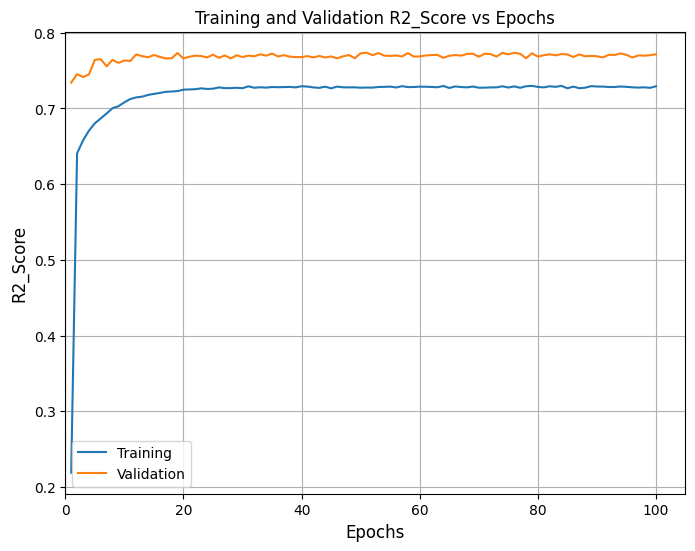

In [ ]:
def plot_training_and_validation_metrics(history, metric):
  if metric not in ["loss", "r2_score"]:
    raise ValueError("Check input")

  df = pd.DataFrame(history.history)
  df["epochs"] = df.index + 1

  fig, ax = plt.subplots(figsize=(8,6))
  ax.plot(df["epochs"], df[metric], label="Training")
  ax.plot(df["epochs"], df[f"val_{metric}"], label="Validation")
  ax.xaxis.get_major_locator().set_params(integer=True)
  ax.axis(xmin=0)
  ax.set_xlabel("Epochs", fontsize=12)
  ax.set_ylabel(metric.title(), fontsize=12)
  ax.set_title(f"Training and Validation {metric.title()} vs Epochs")
  ax.legend()
  ax.grid()
  plt.show()

plot_training_and_validation_metrics(history, "r2_score")

In [ ]:
test_loss, test_r2 = model.evaluate(X_test, y_test)
print("Original Model")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test R2: {test_r2:.4f}")

1949/1949 [==============================] - 7s 4ms/step - loss: 34.7795 - r2_score: 0.7719
Original Model
Test Loss: 34.78
Test R2: 0.7719


In [ ]:
model.save('results.keras')

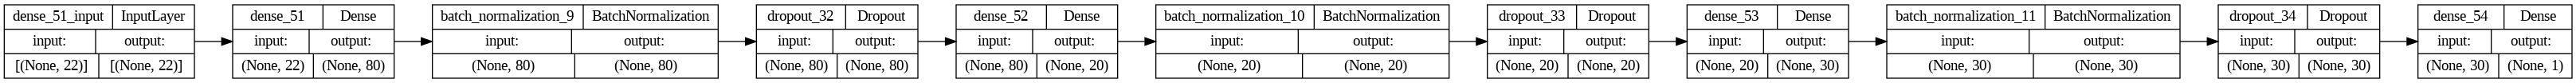

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


# Model Importance

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.6 MB/s eta 0:00:00


In [4]:
import shap
import tensorflow as tf
model = tf.keras.models.load_model('results.keras')


In [7]:
explainer = shap.KernelExplainer(model, X_train)
shap_values = explainer.shap_values(X_train, nsamples=5)


  0%|          | 0/194866 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Index(['TEMPERATURE', 'RELATIVE_HUMIDITY', 'SOLAR_RADIATION', 'PRECIPITATION',
#        'WIND_DIRECTION', 'FLOW_RATE', 'WINDSPEED_SCALAR',
#        'SHELTER_TEMPERATURE', 'NO', 'NOY', 'NOYDIF', 'SO2_GA', 'LATITUDE',
#        'LONGITUDE', 'ELEVATION', 'month', 'Agric', 'Forest', 'Range',
#        'Complex', 'Flat', 'Rolling'],
#       dtype='object')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50[0], X_train[50:100,:])


In [10]:
import numpy as np
explainer = shap.KernelExplainer(model, np.sample(X_train, 1000))

AttributeError: ignored

In [16]:
explainer = shap.KernelExplainer(model, shap.sample(X_train, 50))
shap_values = explainer.shap_values(shap.sample(X_test, 50), n_samples=50)


  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], shap.sample(X_train, 50), feature_names=columns)


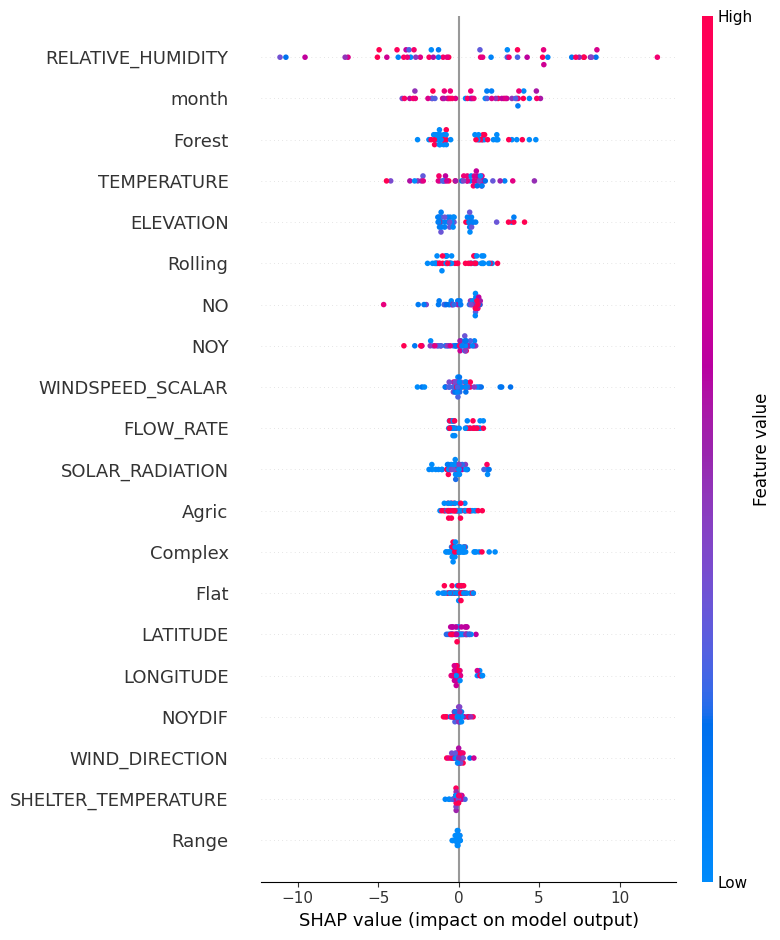

In [22]:
shap.summary_plot(shap_values[0], shap.sample(X_train, 50), feature_names=columns)

